In [530]:
#standard libraries
import pandas as pd, numpy as np

import time

#visualization libraries
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt

#pre-build functions
from pre_build_functions import *

#model learning libraries
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.metrics import classification_report


#hyperparameters
from sklearn.model_selection import cross_val_score
import optuna
from optuna import Trial, study, samplers

import warnings 
warnings.filterwarnings('ignore')

### **Data**

##### Meta File

In [531]:
data_meta = pd.read_csv('./additional_data/meta_information.csv',
                        index_col=0)

data_meta.head(3)

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431


##### *Palm File*

In [532]:
#assign the value of the generator
# length_of_file_number(length=len(data_meta['montage']))
# n = length_of_file_number(length=len(data_meta['montage']))

gestures, current_file, palm_file = read_pilot(data=data_meta,
                                               #file_number=next(n),
                                               file_number=13
                                               )

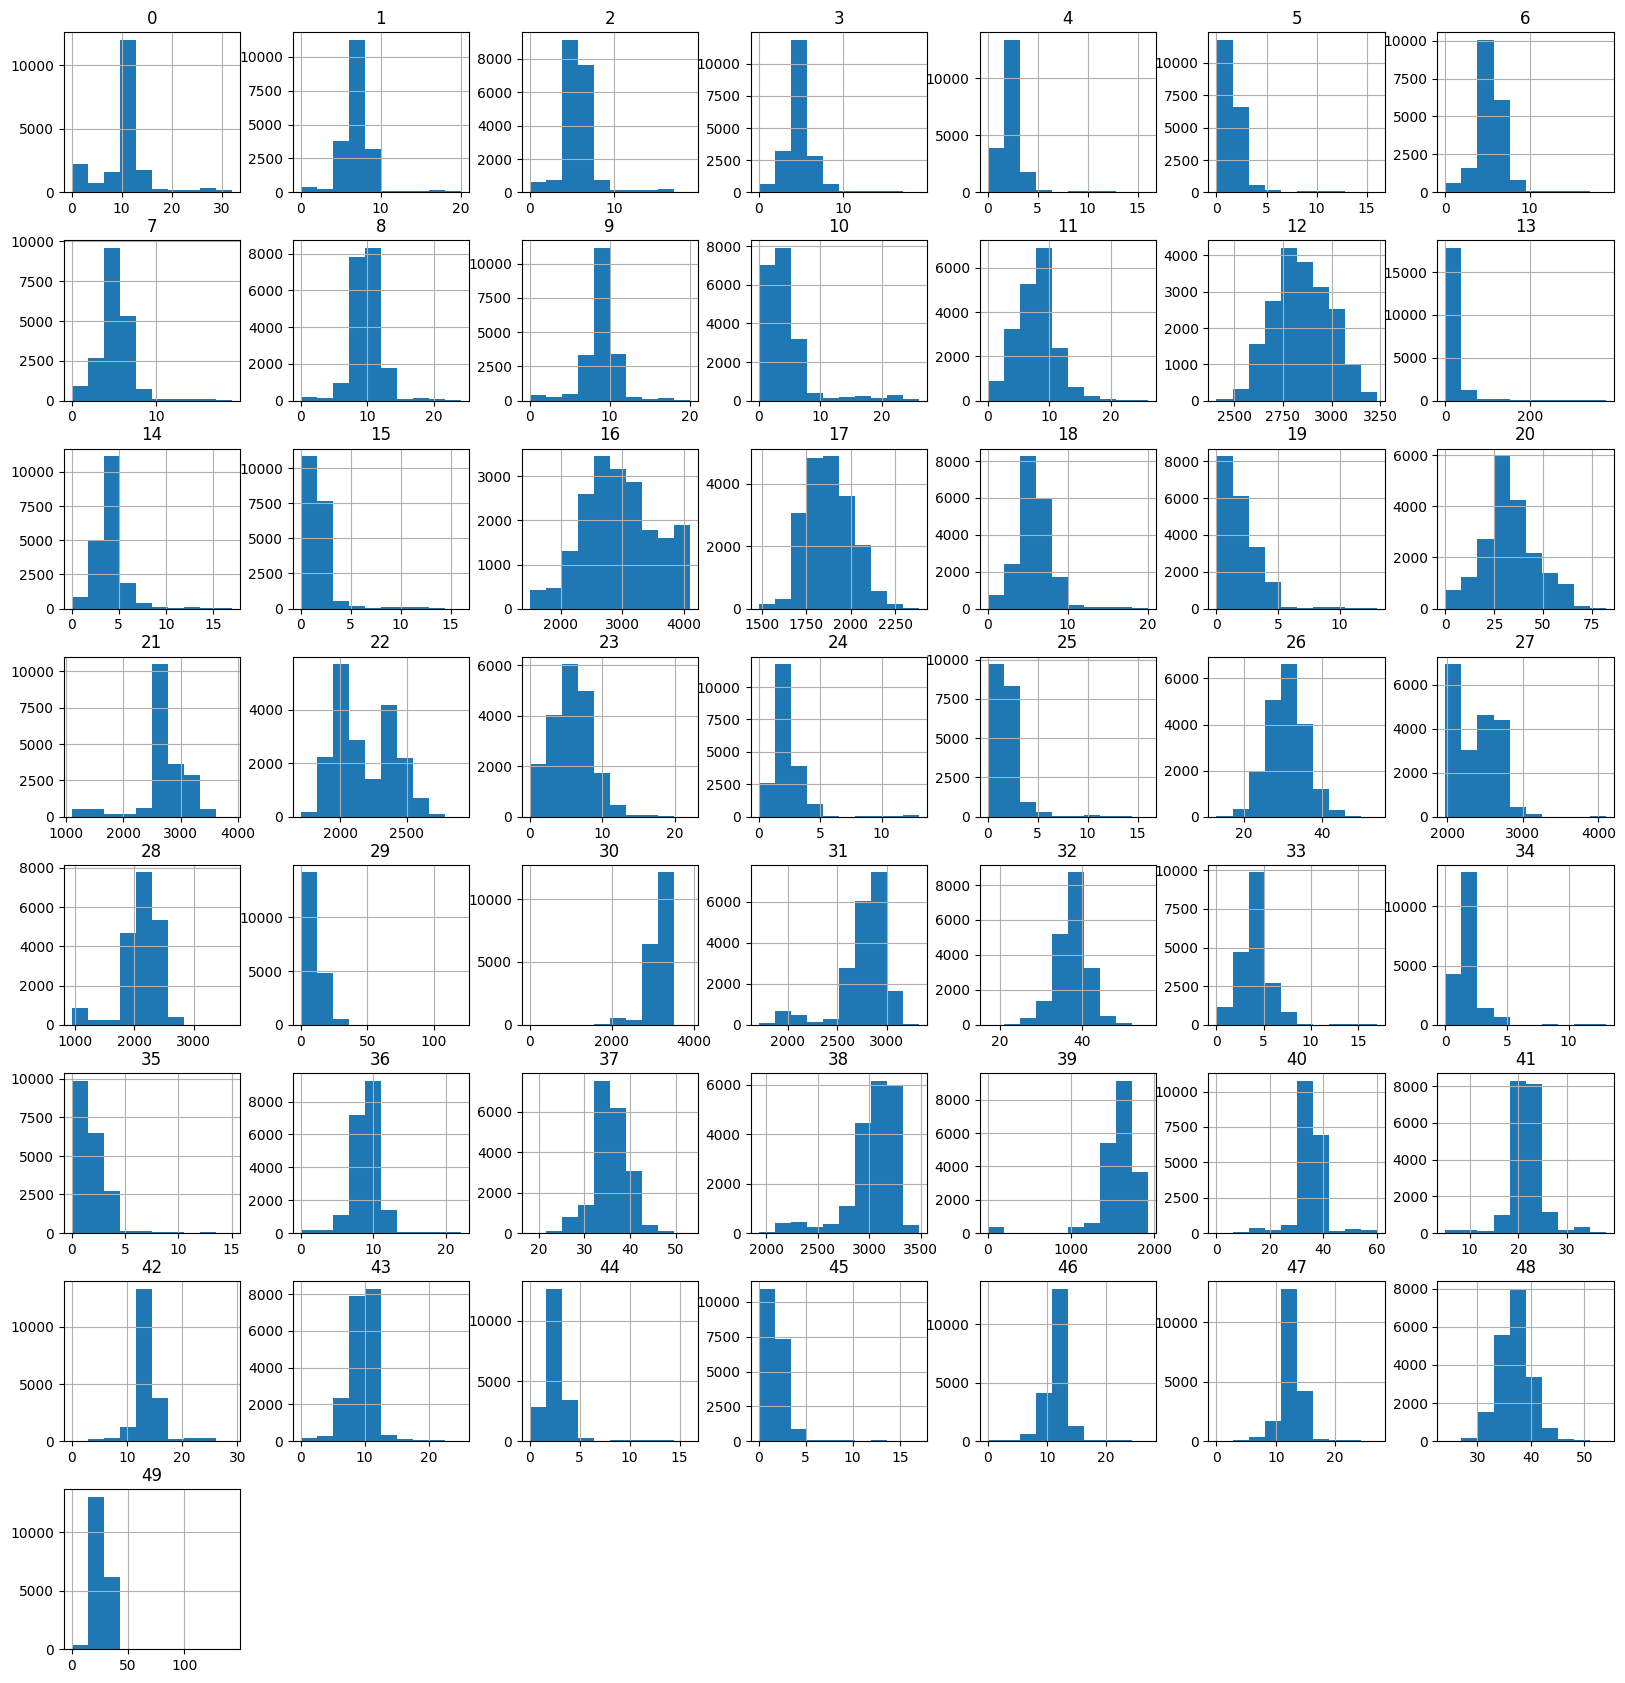

In [533]:
#plot the distribution of values across the sensors
gestures.iloc[:, :50].hist(figsize=(20, 21));

In [534]:
gestures.iloc[:, :50].describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,19568.00,19568.00,19568.00,19568.00,19568.0,19568.00,19568.00,19568.00,19568.00,19568.00,...,19568.00,19568.00,19568.00,19568.00,19568.00,19568.00,19568.00,19568.00,19568.00,19568.00
mean,10.49,6.42,5.47,4.55,2.2,1.40,5.11,4.84,9.61,8.24,...,34.50,21.54,13.61,9.20,2.75,1.50,11.51,12.48,36.45,27.00
std,5.11,2.15,2.20,1.98,1.5,1.71,1.99,2.05,2.13,2.14,...,5.13,3.22,2.58,2.23,1.67,1.69,2.05,2.08,3.04,4.48
min,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00,0.00
25%,10.00,6.00,5.00,4.00,2.0,0.00,4.00,4.00,9.00,8.00,...,33.00,20.00,13.00,8.00,2.00,0.00,10.00,12.00,34.00,26.00
50%,11.00,6.00,5.00,4.00,2.0,1.00,5.00,5.00,10.00,8.00,...,35.00,22.00,14.00,9.00,3.00,1.00,12.00,12.00,36.00,28.00
75%,12.00,7.00,6.00,5.00,2.0,2.00,6.00,6.00,10.00,9.00,...,36.00,23.00,14.00,10.00,3.00,2.00,12.00,13.00,38.00,29.00
max,32.00,20.00,19.00,19.00,16.0,16.00,19.00,19.00,24.00,20.00,...,60.00,38.00,29.00,25.00,16.00,17.00,27.00,27.00,54.00,142.00


In [535]:
#create a dataframe for describe() method
desc = gestures.iloc[:, :50].describe().round(2)

In [536]:
#slice the omg channels
desc_mean = desc.loc['mean']
desc_mean = desc_mean.transpose()

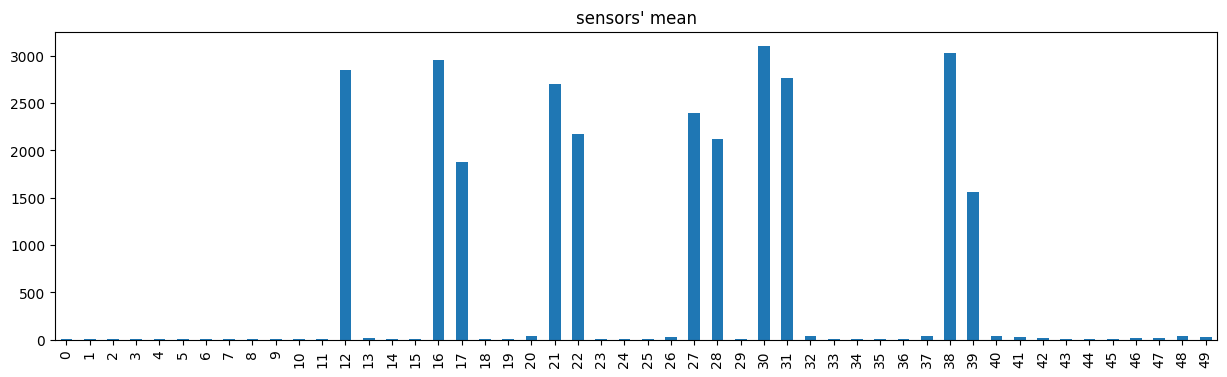

In [537]:
#create a bar chart for mean and standard deviation
desc_mean.plot(kind='bar',
               y='mean',
               legend=False,
               figsize=(15, 4),
               title="sensors' mean");

#### Encoding

##### Protocol File

In [538]:
gestures_protocol = pd.read_csv(f'{"./data_csv/" + current_file}.protocol.csv', index_col=0)

In [539]:
gestures_protocol

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
176,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
177,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
178,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [540]:
gestures_protocol = encoder(current_file, gestures_protocol)

In [541]:
#set the gestures
MAIN_GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
MAIN_GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

#### Predictive Feature

In [542]:
#lock the predictive feature
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

In [543]:
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

#### Shift Function

In [544]:
#apply the time interval shift function
y, summary = get_naive_centering(gestures, y_cmd)

In [545]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [546]:
#display
summary

['Оптимальные свдиги для концевых выборок:   20 и 1\n',
 'Accuracy/correlation на концевых выборках: 0.627; 0.678\n',
 'Размер оптимального сдвига (как среднего): 10']

#### Noise / Inactive Sensors

In [547]:
#assign variables
gestures['y_cmd'] = y

#select sensor features only
data = gestures.iloc[:, :50]

In [548]:
#filter signals
fs = 100 #sampling frequency
lowcut = 0.5
highcut = 45.0

sensor_columns = data.columns

for col in sensor_columns:
    data[col] = filter_signal(data[col], lowcut, highcut, fs)

In [549]:
#find active and inactive sensors
threshold = 20
variances = data[sensor_columns].var()
working_sensors = variances[variances > threshold].index.tolist()
non_working_sensors = variances[variances <= threshold].index.tolist()

data = data[working_sensors]

print(f'Active Sensors: {working_sensors}')
print(f'Inactive Sensors: {non_working_sensors}')

Active Sensors: ['0', '12', '13', '16', '17', '20', '21', '22', '27', '28', '30', '31', '38', '39', '40']
Inactive Sensors: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '14', '15', '18', '19', '23', '24', '25', '26', '29', '32', '33', '34', '35', '36', '37', '41', '42', '43', '44', '45', '46', '47', '48', '49']


In [550]:
#convert the inactive sensors to a numerical index
inactive = []
for s in non_working_sensors:
    inactive.append(int(s))

### **Train-Test Split**

In [551]:
#select specific part of the data set
last_train_idx = data_meta[data_meta['montage'] == current_file].to_dict(orient='records')[0]['last_train_idx']

In [552]:
#select the features for train
X_train = gestures[working_sensors].values[:last_train_idx]
y_train = gestures['y_cmd'][:last_train_idx]


#select the features for test
X_test = gestures[working_sensors].values[last_train_idx:]
y_test = gestures['y_cmd'][last_train_idx:]


#find the dimensions
print(f'train: {X_train.shape, y_train.shape} \n test: {X_test.shape, y_test.shape}')

train: ((15679, 15), (15679,)) 
 test: ((3889, 15), (3889,))


### **Model Learning**

#### Random Forest

In [553]:
#use the Optuna method to look for best hyper parameters
def optuna_rf(trial):
  #set hyperparameters
  n_estimators = trial.suggest_categorical('n_estimators', [15, 25, 50, 75, 100])
  max_depth = trial.suggest_categorical('max_depth', [5, 10, 15, 20, 25, 30])
  min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [2, 3, 4, 5])
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
  
  #use the combinations for model build
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          criterion=criterion,
                                          max_features=max_features,
                                          random_state=42)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
    model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='f1_micro', 
    n_jobs=-1).mean()

  return score

In [554]:
%%time
#begin hyperparameters selection
#create review object
study_optuna_rf = optuna.create_study(study_name='RandomForest',
                                       direction='maximize')

#search for the best combination
study_optuna_rf.optimize(optuna_rf,
                         n_trials=10)

[I 2024-10-18 01:25:58,603] A new study created in memory with name: RandomForest
[I 2024-10-18 01:26:00,068] Trial 0 finished with value: 0.7659270945220193 and parameters: {'n_estimators': 50, 'max_depth': 25, 'min_samples_leaf': 2, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 0 with value: 0.7659270945220193.
[I 2024-10-18 01:26:00,808] Trial 1 finished with value: 0.7469231520359341 and parameters: {'n_estimators': 15, 'max_depth': 5, 'min_samples_leaf': 2, 'criterion': 'entropy', 'max_features': None}. Best is trial 0 with value: 0.7659270945220193.
[I 2024-10-18 01:26:01,899] Trial 2 finished with value: 0.7529184771994923 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 4, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 0 with value: 0.7659270945220193.
[I 2024-10-18 01:26:02,924] Trial 3 finished with value: 0.8076402857793836 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 4, 'criterion': 'entr

CPU times: user 96.2 ms, sys: 36.4 ms, total: 133 ms
Wall time: 21.8 s


In [555]:
#find the best hyperparameters
print(f'Random Forest Hyperparameters: {study_optuna_rf.best_params}')

Random Forest Hyperparameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 4, 'criterion': 'entropy', 'max_features': 'sqrt'}


In [556]:
#find the metrics for test data
model = ensemble.RandomForestClassifier(**study_optuna_rf.best_params,
                                        random_state=42,
                                        )

#set the start_time
start_time = time.time()

#model learning
model.fit(X_train, y_train)

#calculate the model learning time
model_time = round(time.time() - start_time, 2)

#make a prediction
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

In [557]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_train, y_train):.3f}')
print()
print('test data:')
print(f'f1_score: {metrics.f1_score(y_test, y_test_pred_rf, average="micro"):.3f}')
print(f'accuracy: {model.score(X_test, y_test):.3f}')

train data:
f1_score: 0.905
accuracy: 0.905

test data:
f1_score: 0.815
accuracy: 0.815


In [558]:
#display the report
print(classification_report(y_train,
                            y_train_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

print(classification_report(y_test,
                            y_test_pred_rf,
                            target_names=MAIN_GESTURES,
                            digits=3))

              precision    recall  f1-score   support

     Neutral      0.886     0.981     0.931     10161
        Open      0.983     0.823     0.896      1104
      Pistol      0.974     0.765     0.857      1088
       Thumb      0.931     0.736     0.822      1104
          OK      0.912     0.725     0.808      1104
        Grab      0.976     0.784     0.870      1118

    accuracy                          0.905     15679
   macro avg      0.944     0.802     0.864     15679
weighted avg      0.910     0.905     0.903     15679

              precision    recall  f1-score   support

     Neutral      0.806     0.938     0.867      2498
        Open      0.978     0.822     0.894       276
      Pistol      0.866     0.724     0.789       286
       Thumb      0.612     0.395     0.480       276
          OK      0.850     0.391     0.536       276
        Grab      0.845     0.632     0.723       277

    accuracy                          0.815      3889
   macro avg      0.826

In [559]:
#export the classification report into a dataframe
report_rf = classification_report(y_test,
                                  y_test_pred_rf,
                                  target_names=MAIN_GESTURES,
                                  output_dict=True)

test_rf = pd.DataFrame(report_rf)
test_rf

,Neutral,Open,Pistol,Thumb,OK,Grab,accuracy,macro avg,weighted avg
precision,0.806263,0.978448,0.866109,0.612360,0.850394,0.845411,0.814862,0.826497,0.815043
recall,0.937950,0.822464,0.723776,0.394928,0.391304,0.631769,0.814862,0.650365,0.814862
f1-score,0.867135,0.893701,0.788571,0.480176,0.535980,0.723140,0.814862,0.714784,0.802023
support,2498.000000,276.000000,286.000000,276.000000,276.000000,277.000000,0.814862,3889.000000,3889.000000


### **Real-Time Inference**

In [560]:
import time
import serial
from IPython.display import clear_output

In [561]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

#### Inference Utils

In [562]:
def preprocessing(x):
    
    #remove inactive sensors from nd_array
    x = np.delete(x,
                  inactive)
    
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters Filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

### **Inference**

#### OFFLINE
(DATA SET)

In [563]:
df_sim = gestures.iloc[last_train_idx:, :50]
print(df_sim.shape)

(3889, 50)


In [564]:
TIMEOUT = 0.033

DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}

In [565]:
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1

not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3, got 0)
not enough values to unpack (expected 3,

In [566]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 0)
sample_preprocessed.shape = (3889, 15)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


In [567]:
print(classification_report(y_test,
                            y_dct['y_commands'],
                            target_names=MAIN_GESTURES))

              precision    recall  f1-score   support

     Neutral       0.79      0.80      0.79      2498
        Open       0.31      0.72      0.44       276
      Pistol       0.36      0.46      0.40       286
       Thumb       0.33      0.17      0.22       276
          OK       0.32      0.17      0.22       276
        Grab       0.65      0.18      0.29       277

    accuracy                           0.63      3889
   macro avg       0.46      0.42      0.39      3889
weighted avg       0.65      0.63      0.62      3889



In [568]:
timeout = 0.033
print(ts_diff > timeout, round(ts_diff, 3), sep=', ')

False, 0.001
